
ℹ Размеры куба: (53, 105, 105)
Диапазон скоростей: 2528.19 m / s - 5982.22 m / s


<Figure size 1200x500 with 0 Axes>

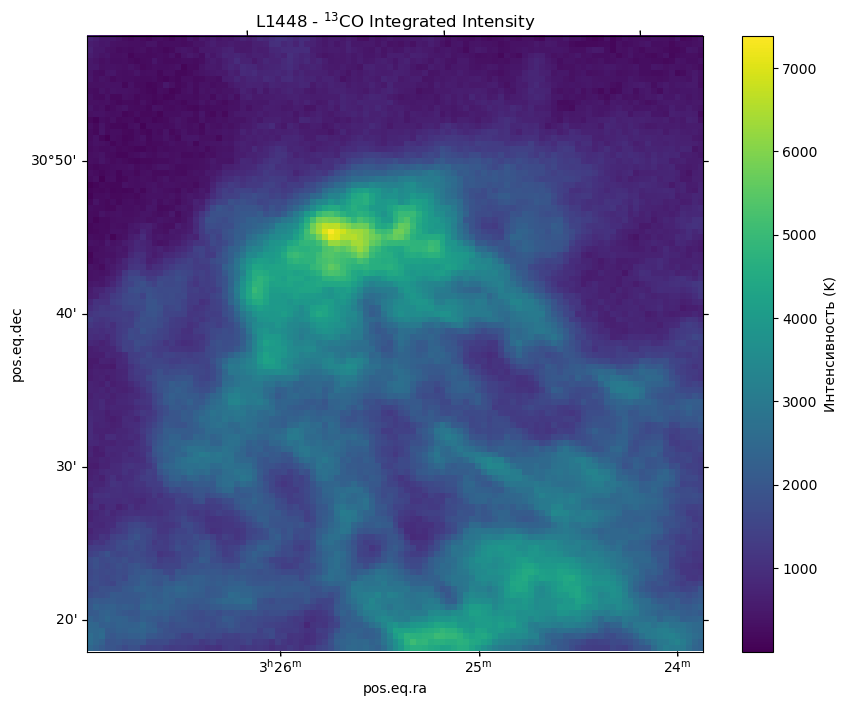


📊 Создаем PV-диаграмму...


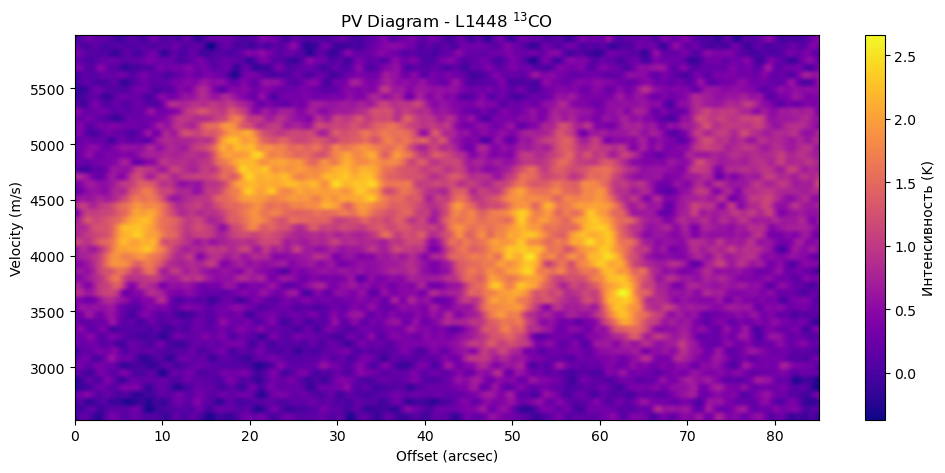

In [11]:
import os
import requests
from spectral_cube import SpectralCube
from tqdm import tqdm
import shutil
import numpy as np
from astropy import units as u
from pvextractor import Path, extract_pv_slice
import matplotlib.pyplot as plt

# Настройки
DATA_URL = "http://www.astropy.org/astropy-data/l1448/l1448_13co.fits"
LOCAL_FILE = "l1448_13co.fits"

def download_file():
    """Скачивание файла с проверкой"""
    if os.path.exists(LOCAL_FILE):
        return True
        
    try:
        print("🛜 Скачиваем данные...")
        response = requests.get(DATA_URL, stream=True)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = 8192
        
        with open(LOCAL_FILE, 'wb') as f, tqdm(
            desc=os.path.basename(LOCAL_FILE),
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                f.write(chunk)
                bar.update(len(chunk))
        return True
    except Exception as e:
        print(f"❌ Ошибка скачивания: {e}")
        return False

def analyze_data():
    """Полный анализ данных"""
    try:
        # Загрузка куба
        cube = SpectralCube.read(LOCAL_FILE)
        print(f"\nℹ Размеры куба: {cube.shape}")
        print(f"Диапазон скоростей: {cube.spectral_axis[0]:.2f} - {cube.spectral_axis[-1]:.2f}")
        
        # 1. Интегрированная карта
        plt.figure(figsize=(10, 8))
        moment0 = cube.moment(order=0)
        ax = plt.subplot(projection=cube.wcs.celestial)
        im = ax.imshow(moment0.value, origin='lower', cmap='viridis')
        plt.colorbar(im, label="Интенсивность (K)")
        ax.set_title("L1448 - $^{13}$CO Integrated Intensity")
        plt.show()
        
        # 2. PV-диаграмма
        create_pv_diagram(cube)
        
    except Exception as e:
        print(f"❌ Ошибка анализа: {e}")

def create_pv_diagram(cube):
    """Создание PV-диаграммы"""
    try:
        print("\n📊 Создаем PV-диаграмму...")
        
        # Центр изображения
        ny, nx = cube.shape[1], cube.shape[2]
        center = (nx//2, ny//2)
        
        # Путь для PV-среза
        path = Path([(center[0]-30, center[1]-30), 
                   (center[0]+30, center[1]+30)])
        
        # Извлечение среза
        pv_slice = extract_pv_slice(cube, path, spacing=1*u.arcsec)
        
        # Визуализация
        plt.figure(figsize=(12, 5))
        plt.imshow(pv_slice.data, origin='lower', aspect='auto',
                  extent=[0, 85,  # Эмпирическая длина в arcsec
                         cube.spectral_axis[0].value,
                         cube.spectral_axis[-1].value],
                  cmap='plasma')
        plt.colorbar(label="Интенсивность (K)")
        plt.title("PV Diagram - L1448 $^{13}$CO")
        plt.xlabel("Offset (arcsec)")
        plt.ylabel("Velocity (m/s)")
        plt.show()
        
    except Exception as e:
        print(f"❌ Ошибка PV-диаграммы: {e}")

# Основной процесс
if download_file():
    analyze_data()
else:
    print("ℹ Скачайте файл вручную и поместите в текущую директорию:")
    print(DATA_URL)